In [179]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [72]:
# Import dataframe after Univariate analysis
df = pd.read_parquet(r"C:\Users\mirko\Desktop\Curso Data Science DL\EDAHospDischarges_Chile2001-2024\data\processed\Discharges_2001-2024_univariate_final.parquet")

In [74]:
# Set category data type instead of object to reduce memory usage
df = df.astype({col: "category" for col in df.select_dtypes(include="object").columns})

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25758741 entries, 0 to 25758740
Data columns (total 13 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   sex                       category
 1   age                       category
 2   health insurance          category
 3   healthcare facility type  category
 4   healthcare facility name  category
 5   length of stay            int32   
 6   discharge condition       category
 7   primary diagnosis code    category
 8   primary diagnosis name    category
 9   year                      int32   
 10  chapter codes             category
 11  chapter names             category
 12  LOS_capped                int32   
dtypes: category(10), int32(3)
memory usage: 614.8 MB


# Create group codes column

In [81]:
# Read excel file and store it as a dataframe, This contains the pairs of group codes and names extracted from the ministry of health ICD10 codes glossary
codes = pd.read_excel(r"C:\Users\mirko\Desktop\Curso Data Science DL\EDAHospDischarges_Chile2001-2024\data\processed\group codes.xlsx")

In [83]:
# Fix column names and headers
codes = codes.iloc[1:].rename(columns = {"Unnamed: 0":"group codes", "Unnamed: 1":"group names"})

In [85]:
# This is a list of the diangosis group codes
group_codes = codes["group codes"].unique()

In [101]:
# This is a list of the diangosis group names
group_names = codes["group names"].unique()

In [87]:
group_codes

array(['A00-A09', 'A15-A19', 'A20-A28', 'A30-A49', 'A50-A64', 'A65-A69',
       'A70-A74', 'A75-A79', 'A80-A89', 'A90-A99', 'B00-B09', 'B15-B19',
       'B20-B24', 'B25-B34', 'B35-B49', 'B50-B64', 'B65-B83', 'B85-B89',
       'B90-B94', 'B95-B98', 'B99', 'C00-C14', 'C15-C26', 'C30-C39',
       'C40-C41', 'C43-C44', 'C45-C49', 'C50', 'C51-C58', 'C60-C63',
       'C64-C68', 'C69-C72', 'C73-C75', 'C76-C80', 'C81-C96', 'C97',
       'D00-D09', 'D10-D36', 'D37-D48', 'D50-D53', 'D55-D59', 'D60-D64',
       'D65-D69', 'D70-D77', 'D80-D89', 'E00-E07', 'E10-E14', 'E15-E16',
       'E20-E35', 'E40-E46', 'E50-E64', 'E65-E68', 'E70-E90', 'F00-F09',
       'F10-F19', 'F20-F29', 'F30-F39', 'F40-F48', 'F50-F59', 'F60-F69',
       'F70-F79', 'F80-F89', 'F90-F98', 'F99', 'G00-G09', 'G10-G14',
       'G20-G26', 'G30-G32', 'G35-G37', 'G40-G47', 'G50-G59', 'G60-G64',
       'G70-G73', 'G80-G83', 'G90-G99', 'H00-H06', 'H10-H13', 'H15-H22',
       'H25-H28', 'H30-H36', 'H40-H42', 'H43-H45', 'H46-H48', 'H49-

In [89]:
# Create temporary column with the first letter of each code and turn it to upper case to avoid conflicts with case differences
df["first letter"] = df["primary diagnosis code"].str[0].str.upper()

In [90]:
# Create temporary column with first 2 digits of each code and convert them to integer
df["two digits"] = df["primary diagnosis code"].str[1:3].astype(int)

In [92]:
# Create empty column to fill with group codes
df["group codes"] = None

In [39]:
df.head()

,sex,age,health insurance,healthcare facility type,healthcare facility name,length of stay,discharge condition,primary diagnosis code,primary diagnosis name,year,chapter codes,chapter names,LOS_capped,first letter,two digits,group codes
0,Male,60-69,Fonasa,Private,Clínica Familia,2,Deceased,C780,tumor maligno secundario del pulmon,2001,C00-D48,Tumores [Neoplasias],2,C,78,None
1,Male,70-79,Fonasa,Public,"Hospital Del Salvador (Santiago, Providencia)",58,Deceased,E145,"diabetes mellitus no especificada, con complic...",2001,E00-E90,"Enfermedades endocrinas, nutricionales y metab...",58,E,14,None
2,Male,70-79,Fonasa,Public,"Hospital Del Salvador (Santiago, Providencia)",12,Deceased,J189,"neumonia, no especificada",2001,J00-J99,Enfermedades del sistema respiratorio,12,J,18,None
3,Male,1-9,Fonasa,Public,Instituto de Neurocirugía Dr. Alfonso Asenjo,1,Deceased,S065,hemorragia subdural traumatica,2001,S00-T98,"Traumatismos, envenenamientos y algunas otras ...",1,S,6,None
4,Male,80-120,Fonasa,Public,Hospital Dr. Leonardo Guzmán (Antofagasta),7,Alive,K830,colangitis,2001,K00-K93,Enfermedades del sistema digestivo,7,K,83,None


In [95]:
# -----------------------------
# Step 0: prepare df
# -----------------------------
# Convert to NumPy arrays for speed
letters = df["first letter"].str.upper().to_numpy()
numbers = df["two digits"].to_numpy(dtype=np.uint8)
group_codes_result = np.full(len(df), None, dtype=object)  # result array

# -----------------------------
# Step 1: handle special single-value codes
# -----------------------------
special_codes = {"B99","C97","F99","N99","T79"}
special_letters = np.array([c[0] for c in special_codes])
special_numbers = np.array([int(c[1:3]) for c in special_codes])

for letter, number in zip(special_letters, special_numbers):
    mask = (group_codes_result == None) & (letters == letter) & (numbers == number)
    group_codes_result[mask] = "special"  # or pick representative code

# -----------------------------
# Step 2: handle general ranges
# -----------------------------
for code in group_codes:
    if code in special_codes:
        continue
    
    parts = code.split("-")
    start = parts[0]
    s_letter, s_number = start[0].upper(), int(start[1:3])
    
    if len(parts) > 1:
        end = parts[1]
        e_letter, e_number = end[0].upper(), int(end[1:3])
    else:
        e_letter, e_number = s_letter, s_number  # single code as range
    
    # Vectorized boolean mask
    mask = (group_codes_result == None) & \
           np.isin(letters, [s_letter, e_letter]) & \
           (numbers >= s_number) & (numbers <= e_number)
    
    group_codes_result[mask] = code

# -----------------------------
# Step 3: assign back to df
# -----------------------------
df["group codes"] = group_codes_result


In [125]:
# Map "special" rows back to their true codes based on first letter + two digits
special_map = {
    ("B", 99): "B99",
    ("C", 97): "C97",
    ("F", 99): "F99",
    ("N", 99): "N99",
    ("T", 79): "T79"
}

mask = df["group codes"] == "special"
df.loc[mask, "group codes"] = [
    special_map[(row["first letter"].upper(), row["two digits"])]
    for _, row in df.loc[mask].iterrows()
]


In [127]:
# The vectorization was succesfull as all the values are valid, even for special cases
df[df["group codes"].isna()]

,sex,age,health insurance,healthcare facility type,healthcare facility name,length of stay,discharge condition,primary diagnosis code,primary diagnosis name,year,chapter codes,chapter names,LOS_capped,first letter,two digits,group codes


In [133]:
# I filled the dictionary, pairing each group code with its corresponding group name
group_names = dict(zip(codes["group codes"], codes["group names"]))

In [135]:
# Vectorization mapping each group name with the corresponding group code and creating a column resulting from it
df["group names"] = df["group codes"].map(group_names)

In [141]:
# Drop transitory columns to keep dataframe clean
df = df.drop(columns = ["first letter", "two digits"])

In [145]:
df = df.astype({col: "category" for col in df.select_dtypes(include="object").columns})

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25758741 entries, 0 to 25758740
Data columns (total 15 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   sex                       category
 1   age                       category
 2   health insurance          category
 3   healthcare facility type  category
 4   healthcare facility name  category
 5   length of stay            int32   
 6   discharge condition       category
 7   primary diagnosis code    category
 8   primary diagnosis name    category
 9   year                      int32   
 10  chapter codes             category
 11  chapter names             category
 12  LOS_capped                int32   
 13  group codes               category
 14  group names               category
dtypes: category(12), int32(3)
memory usage: 713.1 MB


In [165]:
# lower case to make it simple before exporting
df["chapter names"] = df["chapter names"].str.lower()

In [171]:
# Top 5 group names concentrate 4.957.150 discharges (20%)
df["group names"].value_counts().head(5).sum()

4957150

In [175]:
# Add category "other" to plot it next to the top 5 group names
df["group names"] = df["group names"].cat.add_categories("Other")

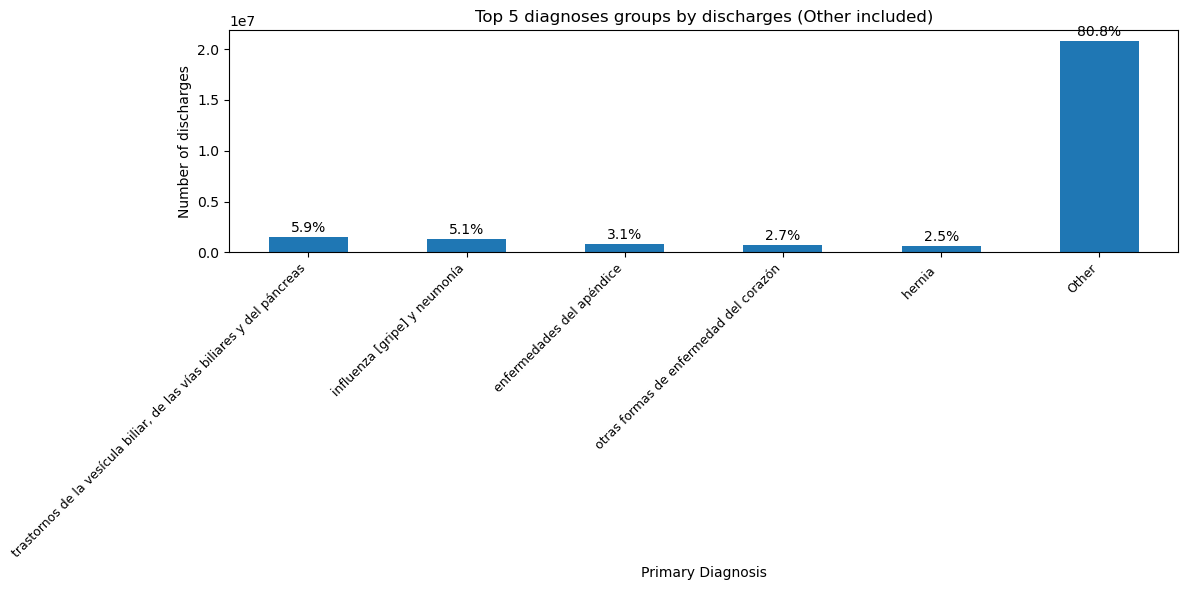

In [185]:
# --- Step 1: Count top 5 diagnoses ---
diag_counts = df["group names"].value_counts()
top_diagnoses = diag_counts.head(5).index.tolist()

# --- Step 2: Create grouped column (Top 5 + "Other") ---
df["diagnosis_grouped"] = df["group names"].where(
    df["group names"].isin(top_diagnoses),
    "Other"
)

# --- Step 3: Aggregate counts by diagnosis ---
counts = df["diagnosis_grouped"].value_counts().loc[top_diagnoses + ["Other"]]

# --- Step 4: Compute percentages for labels ---
percentages = counts / counts.sum() * 100

# --- Step 5: Plot bar chart with frequencies on Y ---
ax = counts.plot(kind="bar", figsize=(12, 6))

plt.ylabel("Number of discharges")
plt.xlabel("Primary Diagnosis")
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.title("Top 5 diagnoses groups by discharges (Other included)")

# --- Step 6: Annotate bars with percentages ---
for i, (count, pct) in enumerate(zip(counts, percentages)):
    ax.text(i, count + (0.01 * counts.max()), f"{pct:.1f}%", 
            ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

In [191]:
# Drop transitory column
df = df.drop(columns = "diagnosis_grouped")

# Export data

In [169]:
# Export dataframe ready for bivariate analysis
df.to_parquet("Discharges_2001-2024_univariate_final_v2_light.parquet", index=False, compression="snappy")